# Classificação de objetos

## 1. Requerimentos

Todas as bibliotecas já estão instaladas no Google Colab.

* OpenCV >= 3.4.3
* Matplotlib >= 3.1.3
* Seaborn >= 0.0.10
* Numpy >= 1.18.1
* Mediapipe==0.10.9

### 1.2 Arquivos

Baixe o repositório do GitHub utilizando o comando abaixo. Em caso de atualização, utilize o comando para apagar o diretório antes.

In [1]:
!rm -rf fiap-ml-visao-computacional/

In [2]:
!git clone https://github.com/FIAPON/fiap-ml-visao-computacional.git

Cloning into 'fiap-ml-visao-computacional'...
remote: Enumerating objects: 65208, done.
remote: Counting objects: 100% (1127/1127), done.
remote: Compressing objects: 100% (864/864), done.
remote: Total 65208 (delta 256), reused 1118 (delta 247), pack-reused 64081 (from 1)
Receiving objects: 100% (65208/65208), 798.52 MiB | 30.75 MiB/s, done.
Resolving deltas: 100% (271/271), done.
Updating files: 100% (66618/66618), done.


Vamos agora posicionar o diretório do repositório para a aula respectiva. Nesse caso envie o comando de mudança de diretório.

In [3]:
%cd /content/fiap-ml-visao-computacional/aula-4-analise-facial

/content/fiap-ml-visao-computacional/aula-4-analise-facial


Importação das bibliotecas.

In [4]:
import numpy as np
import pandas as pd

import glob
from tqdm import tqdm

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import seaborn as sns

import cv2

import math

# Scikit learn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.svm import SVC

#Exibição na mesma tela do Jupyter
%matplotlib inline

import datetime
import dlib

from scipy.spatial import distance as dist

sns.set_style("whitegrid", {'axes.grid' : False})

Carregando um classificador pré-treinado de Haar.

Analise posteriormente outros classificadores disponíveis, dentre eles, classificador de pessoas, automóveis, gatos, sorriso, olhos, etc. neste repositório oficial do OpenCV https://github.com/opencv/opencv/tree/master/data/haarcascades.

## 2. Classificador de Viola-Jones

Este classificador é especializado em identificar faces, também é conhecido como classificador Viola James e pode ser utilizado em outras aplicações. O paper original pode ser baixado [aqui](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf).

Devido a característica deste tipo de classificador, sua identificação é extramamente rápida, com identificação < 0,02s, aplicações em sistemas em tempo real, especialmente câmeras de vigilância.

### 2.1 Classificador de Faces

A aplicação mais utilizada do classificador em cascata de Viola-Jones (ou classificador de Haar) é para encontrar faces em imagens ou vídeos, especialmente por sua identificação ser bem rápida.

Este tipo de classificador serve para separar a região de interesse de uma determinada área, para posteriormente, aplicar outros classificadores que poderão, por exemplo, classificar de quem é o rosto, uma vez que a região foi separado da imagem original.

In [5]:
# Carregando classifcador
classificador_face = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')

imagem = cv2.imread('/content/fiap-ml-visao-computacional/aula-4-analise-facial/imagens/purchase.jpg')
#imagem = cv2.imread('imagens/college.jpg')

imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

(-0.5, 1279.5, 852.5, -0.5)

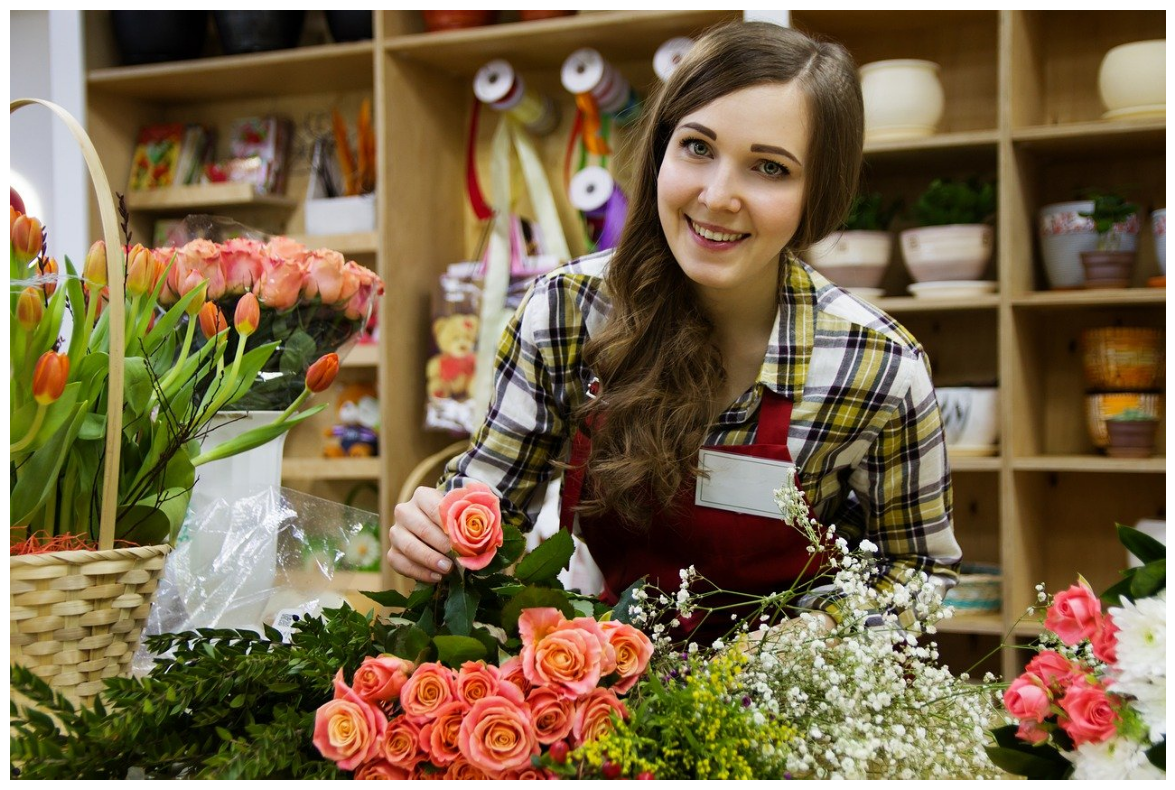

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.axis("off")

Text(0.5, 1.0, 'Faces identificadas')

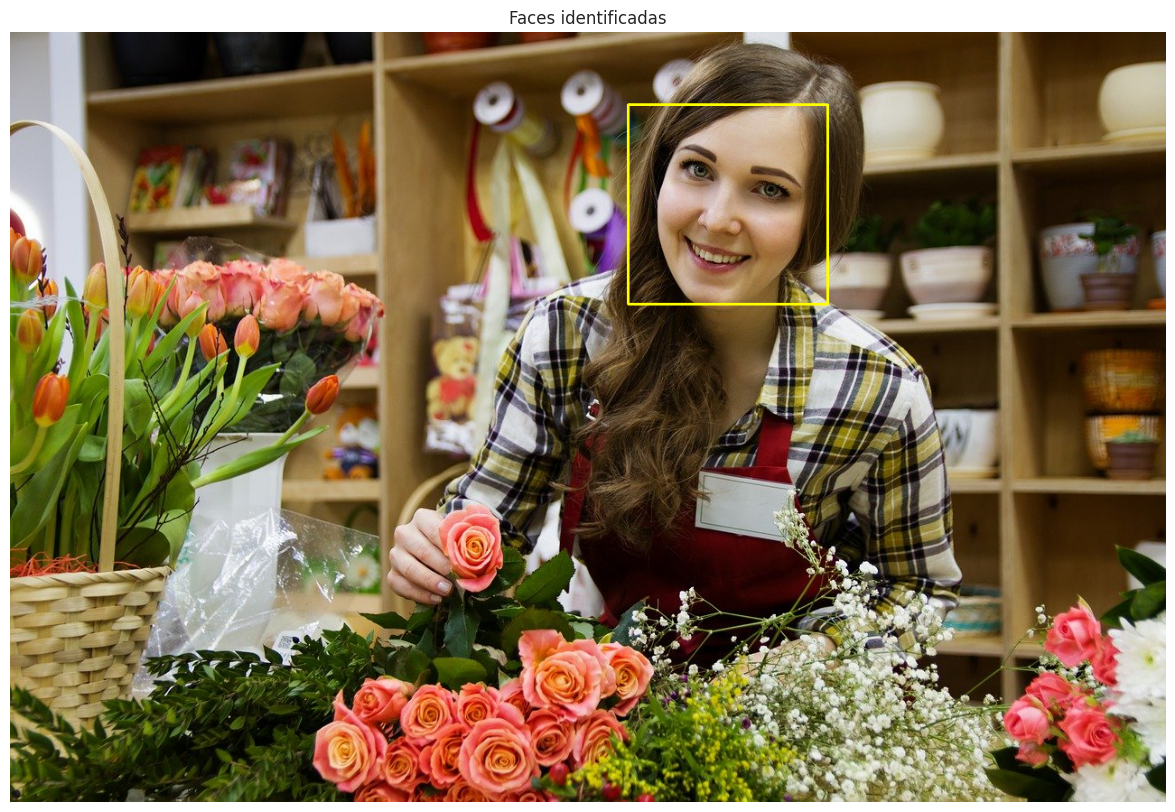

In [7]:
# Retornará a região de interesse da face identificada como tupla, armazenando as coordenadas superiores esquerda e inferior
# direita.
# Se retornar vazio é por que não há faces identificadas.
# Os valores padrão são configurações inciais recomendadas
# (cv.HaarDetectObjects(image, cascade, storage, scale_factor=1.1, min_neighbors=3, flags=0, min_size=(0, 0)))

faces = classificador_face.detectMultiScale(imagem_gray, 1.3, 5)

# Lista de faces. Caso não seja identificada será retornado None (nulo)
if faces is None:
     cv2.putText(imagem, "Rosto ausente", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 6)

# Desenhando retângulos nos rostos identificados
for i, (x,y,w,h) in enumerate(faces):
    roi = imagem[y:y+h, x:x+w]
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)

    cv2.imwrite("face_" + str(i) + ".png", roi)
    cv2.rectangle(imagem, (x,y), (x+w,y+h), (255,255,0), 2)

plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.axis('off')
plt.title("Faces identificadas")

Construindo funções para utilizar de forma modular em análise de imagens ou vídeos.

Optamos por criar 2 versões da mesma função, sendo a com o sufixo **rgb** espera como parâmetro de entrada uma imagem neste formato. A outra função espera como imagem de entrada no formato **bgr**, que é o formato padrão para escrita de vídeo.

Função de análise e inferência para imagens ou frames no formato RGB.

In [8]:
classificador_face = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')

def identificar_rosto_rgb(imagem):

    imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    faces = classificador_face.detectMultiScale(imagem_gray, 1.2, 5)

    for (x,y,w,h) in faces:
        cv2.rectangle(imagem, (x,y), (x+w,y+h), (255,255,0), 2)

    return imagem

Aplicando a uma imagem coletada de uma câmera.

In [13]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [10]:
from IPython.display import Image
try:
  filename = take_photo("imagens/foto.jpg")
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

NotAllowedError: The request is not allowed by the user agent or the platform in the current context.


In [12]:
imagem = cv2.imread("imagens/foto.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
imagem_rosto = identificar_rosto_rgb(imagem)

plt.figure(figsize=(20,10))
plt.imshow(imagem_rosto, cmap="gray")
plt.title("Imagem com rosto")

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


### 2.2 Classificador de Gatos

Este classificador identifica pessoas (corpos inteiros). Sua utilidade é para segmentar e localizar uma ou mais pessoas em uma determinada cena.

Repare que pessoas muito próximas uma das outras prejudica a identificação. Em vídeos de vigilância, este aspecto negativo é diminuído, pois ha muitas oportunidades do classificador inferir, e conseguir identificar as pessoas em outros momentos onde estão mais separadas umas das outroas.

Função de análise e inferência para imagens ou frames no formato RGB.

In [ ]:
def identificar_gato_rgb(imagem):
    classificador_pessoas = cv2.CascadeClassifier('classificadores/haarcascade_frontalcatface_extended.xml')

    imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_RGB2GRAY)
    pessoas = classificador_pessoas.detectMultiScale(imagem_gray, 1.1, 3)

    for (x,y,w,h) in pessoas:
        roi = imagem[y:y+h, x:x+w]
        area = int(w) * int(h)
        cv2.rectangle(imagem, (x,y), (x+w,y+h), (255,255,0), 2)

    return imagem

In [ ]:
imagem = cv2.imread("imagens/cat-dog.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.axis('off')

In [ ]:
imagem_proc = identificar_gato_rgb(imagem)

plt.figure(figsize=(30,20))
plt.imshow(imagem_proc)
plt.axis('off')

### 2.3 Classificador em Cascata Customizado

Construir um classificador em cascata especializado consiste em reunir imagens de treino positivas e negativas, diferentemente de outros tipos de classificadores, como por exemplo os de _deep learning_.

O processo de construção é realizado por meio de utilitários em linha de comando do OpenCV, que apesar de não ser complexo pode envolver uma dedicação maior. Por tal razão, vamos optar pelo [Cascade Trainer GUI](http://amin-ahmadi.com/cascade-trainer-gui/), de Amin Ahmadi, criado para ser executado em Windows que facilita muito este processo. http://amin-ahmadi.com/cascade-trainer-gui/.

As imagens para as etapas de treino podem ser baixadas em http://www.dis.uniroma1.it/~labrococo/?q=node/459.

Função de análise e inferência para imagens ou frames no formato RGB.

In [ ]:
ball_classifier = cv2.CascadeClassifier("ball/classifier/cascade.xml")

def identificar_bola_rgb(imagem):

    gray = cv2.cvtColor(imagem, cv2.COLOR_RGB2GRAY)
    balls = ball_classifier.detectMultiScale(gray, 1.3, 3)

    for (x,y,w,h) in balls:
        cv2.rectangle(imagem, (x,y), (x+w,y+h), (255,255,0), 1)

    return imagem

In [ ]:
imagem = cv2.imread("imagens/soccer-ball.png")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.axis('off')

In [ ]:
imagem_proc = identificar_bola_rgb(imagem)

plt.figure(figsize=(20,20))
plt.imshow(imagem_proc)
plt.axis('off')

# Extra:  Reconhecimento de Placas com Haar Cascade

Exemplo prático de como realizar o reconhecimento de placas de veículos utilizando o classificador Haar Cascade em Python, aproveitando as funcionalidades da biblioteca OpenCV.



In [14]:
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev
!sudo apt-get install tesseract-ocr-por
!pip install pytesseract

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,513 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,738 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd

Placa detectada 1:


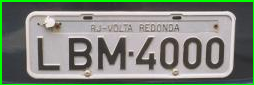

Imagem com placas detectadas:


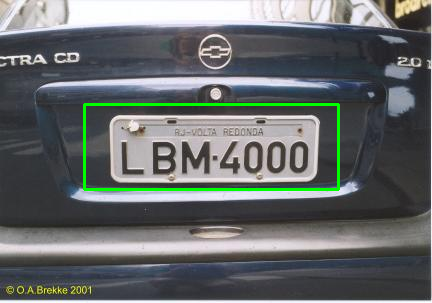

In [15]:
import cv2
from google.colab.patches import cv2_imshow
import pytesseract
import numpy as np


# Carregar o classificador Haar Cascade para placas
cascade_path = 'classificadores/haarcascade_russian_plate_number.xml'  # Substitua pelo caminho do arquivo XML
plate_cascade = cv2.CascadeClassifier(cascade_path)

# Carregar a imagem
image_path = 'imagens/br_lbm-4000.jpg'  # Substitua pelo caminho da sua imagem
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detectar placas na imagem
plates = plate_cascade.detectMultiScale(gray_image, scaleFactor=1.2, minNeighbors=5, minSize=(30, 30))

# Processar as detecções
for i, (x, y, w, h) in enumerate(plates):
    # Desenhar retângulo ao redor da placa
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Extrair a região de interesse (ROI) da placa
    roi = image[y:y + h, x:x + w]

    # Exibir a ROI da placa detectada
    print(f"Placa detectada {i + 1}:")
    cv2_imshow(roi)

# Mostrar a imagem completa com as placas detectadas
print("Imagem com placas detectadas:")
cv2_imshow(image)


Placa detectada 1 (pré-processada):


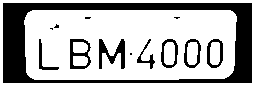

Texto detectado na placa 1: LBM4000
Imagem com placas detectadas:


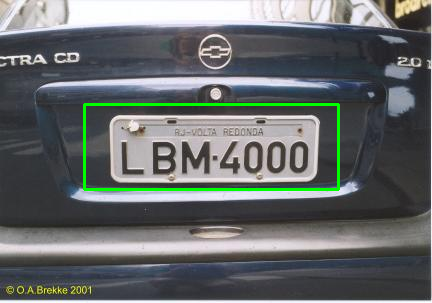

In [16]:

# Função para pré-processar a ROI da placa
def preprocess_plate(plate_roi):
    # Converter a imagem para escala de cinza
    gray = cv2.cvtColor(plate_roi, cv2.COLOR_BGR2GRAY)

    # Aplicar o filtro bilateral para reduzir o ruído e manter as bordas
    filtered = cv2.bilateralFilter(gray, 11, 17, 17)

    # Aplicar a binarização com o método Otsu
    _, thresh = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Aplicar operações morfológicas para melhorar os caracteres
    kernel = np.ones((3, 3), np.uint8)
    morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

    return morphed

# Inicializar o OCR (Tesseract)
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'  # Caminho do executável do Tesseract

# Iterar sobre as placas detectadas
for i, (x, y, w, h) in enumerate(plates):
    # Extrair a região de interesse (ROI) da placa
    roi = image[y:y + h, x:x + w]

    # Pré-processar a ROI da placa
    processed_roi = preprocess_plate(roi)

    # Exibir a ROI da placa pré-processada
    print(f"Placa detectada {i + 1} (pré-processada):")
    cv2_imshow(processed_roi)

    # Aplicar OCR para ler a placa (em português)
    custom_config = r'--oem 3 --psm 6 -l por'  # Configuração do OCR para português
    plate_text = pytesseract.image_to_string(processed_roi, config=custom_config)

    # Mostrar o texto detectado
    print(f"Texto detectado na placa {i + 1}: {plate_text.strip()}")

# Mostrar a imagem completa com as placas detectadas
print("Imagem com placas detectadas:")
cv2_imshow(image)


# Faça você mesmo:

Use o haarcascade `classificadores\haarcascade_fullbody.xml` para fazer a detecção de um corpo da imagem `imagens\full_body.jpg`

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Carrega a imagem e converter canais de cores
imagem = #IMPLEMENTAR

# Carrega o classificador Haar Cascade para corpos inteiros
fullbody_cascade = #IMPLEMENTAR

# Converte a imagem para escala de cinza
gray = #IMPLEMENTAR

# Detecta corpos inteiros
# detectMultiScale
#     - Adicionar os valores que scaleFactor e minNeighbors
corpos = #IMPLEMENTAR

# Desenha os retângulos ao redor dos corpos detectados
for (x, y, w, h) in corpos:
    cv2.rectangle(imagem, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.axis('off')

# LBPH - Local Binary Pattern Histogram

## É preciso restart do Kernel

In [17]:
!pip uninstall opencv_contrib_python
!pip install opencv_contrib_python

Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cv2/*
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python-4.10.0.84.dist-info/*
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Core-e6d3f451.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Gui-5dea4132.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Test-d435aae7.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Widgets-e392eaf8.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5XcbQpa-3bf8a55a.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.10

In [2]:

!unzip faces.zip

Archive:  faces.zip
   creating: faces/
   creating: faces/faces/
   creating: faces/faces/Teste/
  inflating: faces/faces/Teste/image_0047.jpg  
  inflating: faces/faces/Teste/image_0318.jpg  
   creating: faces/faces/Train/
  inflating: faces/faces/Train/image_0001.jpg  
  inflating: faces/faces/Train/image_0002.jpg  
  inflating: faces/faces/Train/image_0003.jpg  
  inflating: faces/faces/Train/image_0004.jpg  
  inflating: faces/faces/Train/image_0005.jpg  
  inflating: faces/faces/Train/image_0006.jpg  
  inflating: faces/faces/Train/image_0007.jpg  
  inflating: faces/faces/Train/image_0008.jpg  
  inflating: faces/faces/Train/image_0009.jpg  
  inflating: faces/faces/Train/image_0010.jpg  
  inflating: faces/faces/Train/image_0011.jpg  
  inflating: faces/faces/Train/image_0012.jpg  
  inflating: faces/faces/Train/image_0013.jpg  
  inflating: faces/faces/Train/image_0014.jpg  
  inflating: faces/faces/Train/image_0015.jpg  
  inflating: faces/faces/Train/image_0016.jpg  
  infl

In [5]:
%cd /content/fiap-ml-visao-computacional/aula-4-analise-facial

/content/fiap-ml-visao-computacional/aula-4-analise-facial


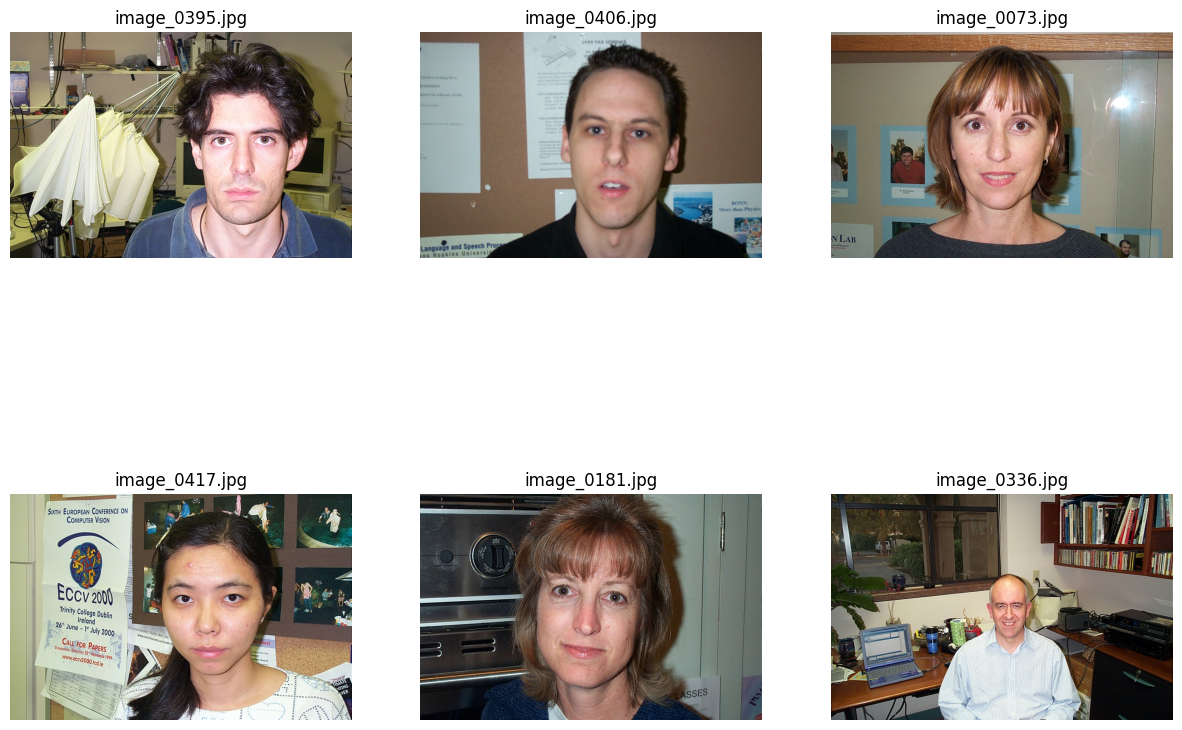

In [7]:
# Importando as bibliotecas necessárias
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


# Definindo o caminho para as imagens
faces_folder_path = 'faces/faces/Train'

# Listando as imagens
image_files = [f for f in os.listdir(faces_folder_path) if f.endswith('.jpg')]

# Visualizando algumas imagens do dataset
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.ravel()
    for i in range(rows * cols):
        image = cv2.imread(os.path.join(faces_folder_path, images[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.subplots_adjust(hspace=0.5)
    plt.show()

# Plotando 6 imagens para visualização inicial
plot_images(image_files[:6], image_files[:6], 2, 3)


In [8]:
# Carregando as imagens e preparando os dados para treinamento
faces = []
labels = []
label_dict = {}
label_counter = 0

# Definindo o caminho para o diretório com imagens
faces_folder_path = 'faces/faces/Train'
image_files = os.listdir(faces_folder_path)

for i, file_name in enumerate(image_files):
    image_path = os.path.join(faces_folder_path, file_name)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is not None:
        faces.append(image)
        # Usando um label único para cada imagem (pode ser modificado para agrupar por pessoa)
        labels.append(label_counter)
        label_dict[label_counter] = file_name
        label_counter += 1

faces = np.array(faces)
labels = np.array(labels)

In [9]:
# Treinando o reconhecedor
lbph_recognizer = cv2.face.LBPHFaceRecognizer_create()
lbph_recognizer.train(faces, labels)

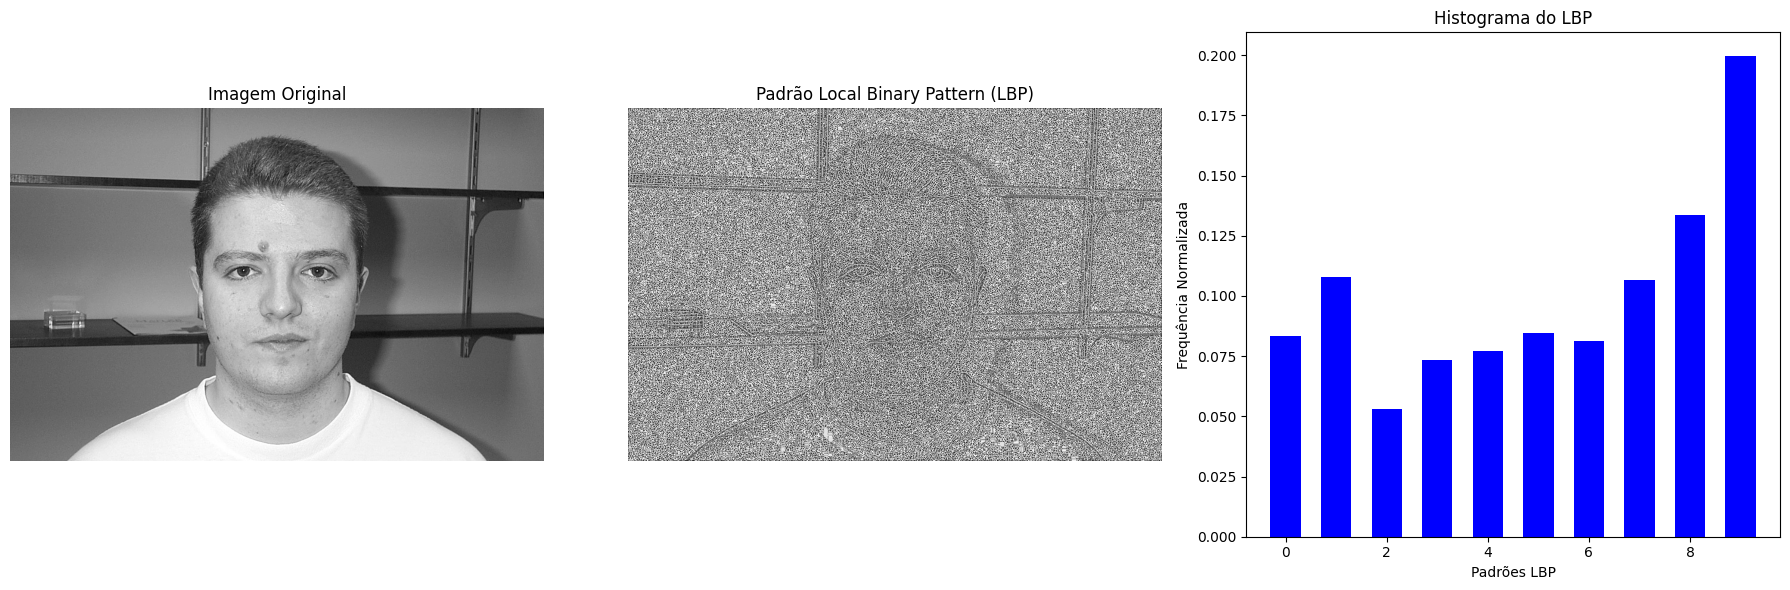

In [11]:
# Importando as bibliotecas necessárias
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

# Função para calcular e plotar os padrões LBP de uma imagem
def plot_lbp(image_path, radius=1, n_points=8):

    # Carregando a imagem em escala de cinza
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print("Erro: Imagem não encontrada ou inválida.")
        return

    # Calculando o padrão LBP da imagem
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')

    # Calculando o histograma do LBP
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalizando o histograma
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)

    # Plotando a imagem original, a imagem LBP e o histograma
    plt.figure(figsize=(18, 6))

    # Imagem original
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')

    # Imagem LBP
    plt.subplot(1, 3, 2)
    plt.imshow(lbp, cmap='gray')
    plt.title('Padrão Local Binary Pattern (LBP)')
    plt.axis('off')

    # Histograma do LBP
    plt.subplot(1, 3, 3)
    plt.bar(range(len(hist)), hist, width=0.6, color='b')
    plt.title('Histograma do LBP')
    plt.xlabel('Padrões LBP')
    plt.ylabel('Frequência Normalizada')

    plt.tight_layout()
    plt.show()

# Caminho para a imagem de teste
test_image_path = 'faces/faces/Teste/image_0047.jpg'

# Chamando a função para visualizar o LBP da imagem de teste
plot_lbp(test_image_path)


In [12]:
def recognize_face(image_path):
    # Carregando imagem de teste
    test_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if test_img is None:
        print("Erro: Imagem de teste não encontrada ou inválida.")
        return

    # Executando o reconhecimento
    label, confidence = lbph_recognizer.predict(test_img)

    # Encontrando o nome do label
    recognized_name = label_dict.get(label, "Desconhecido")
    recognized_image_path = os.path.join(faces_folder_path, label_dict[label])
    recognized_img = cv2.imread(recognized_image_path, cv2.IMREAD_GRAYSCALE)

    # Concatenando as imagens lado a lado
    combined_image = np.hstack((test_img, recognized_img))

    # Exibindo os resultados
    print(f"Face reconhecida: {recognized_name} com confiança de {confidence}")
    print("Imagem de teste e imagem mais similar encontrada:")
    cv2_imshow(combined_image)


Face reconhecida: image_0063.jpg com confiança de 7.954570099162298
Imagem de teste e imagem mais similar encontrada:


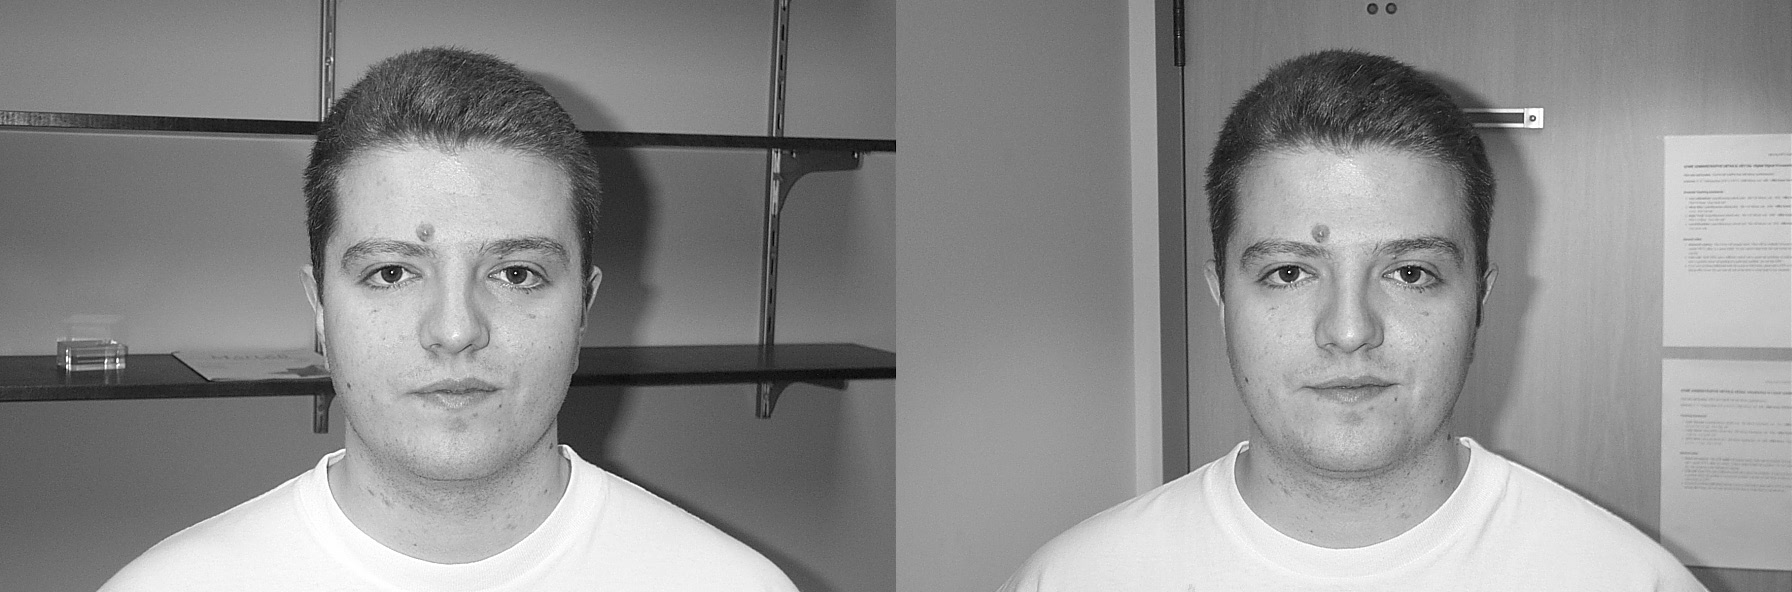

In [14]:
recognize_face('faces/faces/Teste/image_0047.jpg')

## 3. Identificação de Marcos Faciais

O toolkit [Dlib](http://dlib.net) fornece uma série de bibliotecas e ferramentas para utilização em problemas de visão computacional. Para o uso de identificação de marcos faciais vamos utilizar sua biblioteca responsável por identificar faces de uma imagem e posterior identificação dos marcos faciais.

O Dlib vem instalado por padrão na plataforma Google Colab, não é necesário baixar.

Os modelos podem ser baixados neste endereço http://dlib.net/files/. Os que serão utilizados estão já incluídos na pasta ```modelos```.

Iniciamos o processo de identificação configurando o modelo treinado de 68 pontos ```shape_predictor_68_face_landmarks.dat```. Após isso precisamos identificar a face e para cada face identificada retornar a lista de pontos, na variável ```marcos_faciais```.

In [ ]:
classificador_68_path = "modelos/shape_predictor_68_face_landmarks.dat"
classificador_5_path = "modelos/shape_predictor_5_face_landmarks.dat"

classificador_dlib_68 = dlib.shape_predictor(classificador_68_path)
classificador_dlib_5 = dlib.shape_predictor(classificador_5_path)

detector_face_dlib = dlib.get_frontal_face_detector()

def obter_marcos(imagem, marcos_68_pontos=True):

    classificador_dlib = classificador_dlib_68

    if marcos_68_pontos is False:
        classificador_dlib = classificador_dlib_5

    faces = detector_face_dlib(imagem, 1)

    if len(faces) == 0:
        return None

    marcos_faciais = []
    pontos_x, pontos_y, pontos = [], [], []

    for face in faces:
      shape = classificador_dlib_68(imagem, face)

      for i in range(0, 68):
        pontos_x.append(shape.part(i).x)
        pontos_y.append(shape.part(i).y)
        pontos.append([shape.part(i).x, shape.part(i).y])

      pontos = np.matrix(pontos)

      marcos_faciais.append(pontos)

    return marcos_faciais

Com os pontos mapeados, o próximo passo é criar uma função para anotar em uma nova imagem.

In [ ]:
def anotar_marcos(imagem, marcos_faciais):

    if marcos_faciais is None:
        print("Não foi identificado nenhum marco facial.")
        return imagem

    for marco_facial in marcos_faciais:
        for idx, ponto in enumerate(marco_facial):
            centro = (ponto[0,0], ponto[0,1])

            cv2.circle(imagem, centro, 3, (0, 255, 255), -1)

    return imagem

In [ ]:
imagem = cv2.imread("imagens/doctor.jpg")

marcos_faciais = obter_marcos(imagem)
imagem_marcos = anotar_marcos(imagem, marcos_faciais)

imagem_marcos = cv2.cvtColor(imagem_marcos, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,20))
plt.axis('off')
plt.imshow(imagem_marcos)

In [ ]:
imagem = cv2.imread("imagens/doctor.jpg")

marcos_faciais = obter_marcos(imagem, False)
imagem_marcos = anotar_marcos(imagem, marcos_faciais)

imagem_marcos = cv2.cvtColor(imagem_marcos, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,20))
plt.axis('off')
plt.imshow(imagem_marcos)

Aplicando a detecção e anotação utilizando uma câmera.

In [15]:
from IPython.display import Image
try:
  filename = take_photo("imagens/foto.jpg")
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

name 'take_photo' is not defined


In [ ]:
imagem = cv2.imread("imagens/foto.jpg")

marcos_faciais = obter_marcos(imagem)
imagem_marcos = anotar_marcos(imagem, marcos_faciais)

imagem_marcos = cv2.cvtColor(imagem_marcos, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,20))
plt.axis('off')
plt.imshow(imagem_marcos)
plt.title("Marcos faciais da câmera")

### 3.1 Análise de Marcos Faciais

Os 68 pontos estão divididos nos seguintes coponentes do rosto humano:

* Face completa ```1 ao 68```
* Sombrancelha direita ```17 ao 21```
* Sombracelha esquerda ```22 ao 26```
* Olho direito ```36 ao 41```
* Olho esquerdo ```42 ao 47```
* Nariz ```27 ao 34```
* Lábio ```48 ao 60```
* Lábio exterior ``47 a 60``
* Lábio interior ``59 a 67``  
* Mandíbula ```1 ao 16```

Os pontos que o DLib retorna são zero based, portanto o primeiro ponto começa no 0.

In [ ]:
FACE_COMPLETA = list(range(0, 68))
SOMBRANCELHA_DIREITA = list(range(17, 22))
SOMBRANCELHA_ESQUERDA = list(range(22, 27))
OLHO_DIREITO = list(range(36, 42))
OLHO_ESQUERDO = list(range(42, 48))
NARIZ = list(range(27, 35))
LABIO = list(range(48, 61))
LABIO_EXTERIOR = list(range(48, 61))
LABIO_INTERIOR = list(range(60, 68))
MANDIBULA = list(range(0, 17))

Função para criar polígonos a partir dos pontos de identificação. Estes polígonos podem oferecer ferramentas como cálculo de área para identificação melhor das estruturas faciais, como piscadas, movimentação da boca, dentre outros.

In [ ]:
def anotar_marcos_faciais_componente(imagem, marcos_faciais):

    if marcos_faciais is None:
        print("Não foi identificado nenhum marco facial.")
        return imagem

    for marco_facial in marcos_faciais:
        for d in marco_facial:

            pontos = cv2.convexHull(marco_facial[LABIO])
            cv2.drawContours(imagem, [pontos], 0, (0, 255, 0), 2)

            pontos = cv2.convexHull(marco_facial[OLHO_ESQUERDO])
            cv2.drawContours(imagem, [pontos], 0, (0, 255, 0), 2)

            pontos = cv2.convexHull(marco_facial[OLHO_DIREITO])
            cv2.drawContours(imagem, [pontos], 0, (0, 255, 0), 2)

    return imagem

In [ ]:
imagem = cv2.imread("imagens/cervero.jpeg")

marcos_faciais = obter_marcos(imagem)
imagem_marcos = anotar_marcos_faciais_componente(imagem, marcos_faciais)

imagem_marcos = cv2.cvtColor(imagem_marcos, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,20))
plt.axis('off')
plt.imshow(imagem_marcos)

In [ ]:
imagem = cv2.imread("imagens/bruce.jpg")

marcos_faciais = obter_marcos(imagem)
imagem_marcos = anotar_marcos_faciais_componente(imagem, marcos_faciais)

imagem_marcos = cv2.cvtColor(imagem_marcos, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,20))
plt.axis('off')
plt.imshow(imagem_marcos)

Para lidar com situações onde o rosto capturado pode se aproximar ou se afastar da câmera utilizamos um cálculo de aspecto de razão. Esse cálculo divide duas medidas e sua razão é utilizada como medida para análises.

Uma vez que temos os pontos em volta de cada componente do rosto humano é possível realizar essas medidas de aspecto de razão para analisar a abertura dos olhos, por exemplo.

Nesse sentido, calculamos a medida de aspecto razão dos olhos ou EAR. Essa medida foi discutida neste [paper de Soukupová and Čech](http://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf).

In [ ]:
def ear(pontos_olho):
    # Converter os pontos em vetores 1-D
    ponto1 = np.array([pontos_olho[1][0, 0], pontos_olho[1][0, 1]])
    ponto2 = np.array([pontos_olho[2][0, 0], pontos_olho[2][0, 1]])
    ponto3 = np.array([pontos_olho[3][0, 0], pontos_olho[3][0, 1]])
    ponto4 = np.array([pontos_olho[4][0, 0], pontos_olho[4][0, 1]])
    ponto5 = np.array([pontos_olho[5][0, 0], pontos_olho[5][0, 1]])

    # Calcular as distâncias entre os pontos
    a = dist.euclidean(ponto2, ponto5)
    b = dist.euclidean(ponto3, ponto4)
    c = dist.euclidean(ponto1, ponto4)

    # Calcular a medida ear
    medida_ear = (a + b) / (2.0 * c)

    return medida_ear

def obter_pontos_olho(marcos_faciais, olho_indices):
    pontos_olho = []
    for idx in olho_indices:
        pontos_olho.append(marcos_faciais[0][idx])
    return pontos_olho


Vamos inspecionar a abertura dos olhos da imagem analisada. Note que como existe apenas uma única pessoa (ou rosto) na imagem,  utilizaremos o índice 0 somente. Se houvessem mais pessoas, poderíamos analisar cada uma delas iterando sobre o índice.

In [ ]:
pontos_olho_direito = obter_pontos_olho(marcos_faciais, OLHO_DIREITO)
ear_olho_direito = ear(pontos_olho_direito)
print("EAR do olho direito " + str(ear_olho_direito))

pontos_olho_esquerdo = obter_pontos_olho(marcos_faciais, OLHO_ESQUERDO)
ear_olho_esquerdo = ear(pontos_olho_esquerdo)
print("EAR do olho direito " + str(ear_olho_direito))

In [ ]:
imagem = cv2.imread("imagens/person-closed-yes.jpg")

marcos_faciais = obter_marcos(imagem)
imagem_marcos = anotar_marcos_faciais_componente(imagem, marcos_faciais)

imagem_marcos = cv2.cvtColor(imagem_marcos, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,20))
plt.axis('off')
plt.imshow(imagem_marcos)

In [ ]:
pontos_olho_direito = obter_pontos_olho(marcos_faciais, OLHO_DIREITO)
ear_olho_direito = ear(pontos_olho_direito)
print("EAR do olho direito " + str(ear_olho_direito))

pontos_olho_esquerdo = obter_pontos_olho(marcos_faciais, OLHO_ESQUERDO)
ear_olho_esquerdo = ear(pontos_olho_esquerdo)
print("EAR do olho direito " + str(ear_olho_direito))

In [ ]:
imagem = cv2.imread("imagens/amazed.jpg")

marcos_faciais = obter_marcos(imagem)
imagem_marcos = anotar_marcos_faciais_componente(imagem, marcos_faciais)

imagem_marcos = cv2.cvtColor(imagem_marcos, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,20))
plt.axis('off')
plt.imshow(imagem_marcos)

In [ ]:
pontos_olho_direito = obter_pontos_olho(marcos_faciais, OLHO_DIREITO)
ear_olho_direito = ear(pontos_olho_direito)
print("EAR do olho direito " + str(ear_olho_direito))

pontos_olho_esquerdo = obter_pontos_olho(marcos_faciais, OLHO_ESQUERDO)
ear_olho_esquerdo = ear(pontos_olho_esquerdo)
print("EAR do olho direito " + str(ear_olho_direito))

Aplicar a análise de face e marcos faciais utilizando a câmera.

In [ ]:
from IPython.display import Image
try:
  filename = take_photo("imagens/foto.jpg")
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
imagem = cv2.imread("imagens/foto.jpg")

marcos_faciais = obter_marcos(imagem)
imagem_marcos = anotar_marcos_faciais_componente(imagem, marcos_faciais)

imagem_marcos = cv2.cvtColor(imagem_marcos, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,20))
plt.axis('off')
plt.imshow(imagem_marcos)
plt.title("Marcos faciais com 68 pontos")

In [ ]:
pontos_olho_direito = obter_pontos_olho(marcos_faciais, OLHO_DIREITO)
ear_olho_direito = ear(pontos_olho_direito)
print("EAR do olho direito " + str(ear_olho_direito))

pontos_olho_esquerdo = obter_pontos_olho(marcos_faciais, OLHO_ESQUERDO)
ear_olho_esquerdo = ear(pontos_olho_esquerdo)
print("EAR do olho direito " + str(ear_olho_direito))

### 3.2 Alinhamento de faces

Uma técnica de pré-processamento de imagens contendo faces humanas é o alinhamento dos olhos. Esta técnica torna as regiões entre as difernetes imagens em uma mesma localização espacial, o que torna o aprendizado de reconhecimento de faces mais efetivo.

In [ ]:
def extrair_olho(shape, eye_indices):
    points = map(lambda i: shape.part(i), eye_indices)
    return list(points)

def extrair_olho_centro(shape, eye_indices):
    points = extrair_olho(shape, eye_indices)
    xs = map(lambda p: p.x, points)
    ys = map(lambda p: p.y, points)
    return sum(xs) // 6, sum(ys) // 6

def extrair_olho_centro_esquerdo(shape):
    return extrair_olho_centro(shape, OLHO_ESQUERDO)

def extrair_olho_centro_direito(shape):
    return extrair_olho_centro(shape, OLHO_DIREITO)

def angulo_entre_pontos(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    tan = (y2 - y1) / (x2 - x1)
    return np.degrees(np.arctan(tan))

def get_rotation_matrix(p1, p2):
    angle = angulo_entre_pontos(p1, p2)
    x1, y1 = p1
    x2, y2 = p2
    xc = (x1 + x2) // 2
    yc = (y1 + y2) // 2
    M = cv2.getRotationMatrix2D((xc, yc), angle, 1)
    return M

def align_face(image_path, tamanho=None, return_face=False):
  imagem = cv2.imread(image_path)
  imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

  height, width = imagem.shape[:2]
  dets = detector_face_dlib(imagem, 1)

  if len(dets) == 0:
    return None

  for i, det in enumerate(dets):

      x = det.left()
      y = det.top()
      w = det.right() - x
      h = det.bottom() - y

      if x < 0: x = 0
      if y < 0: y = 0

      roi = imagem[y:y+h, x:x+w]

      shape = classificador_dlib_68(imagem, det)
      left_eye = extrair_olho_centro_esquerdo(shape)
      right_eye = extrair_olho_centro_direito(shape)

      M = get_rotation_matrix(left_eye, right_eye)

      if tamanho:
        width = tamanho[0]
        height = tamanho[1]

      rotated = cv2.warpAffine(imagem, M, (width, height))

      cropped = rotated[y:y+h, x:x+w]

  if return_face:
    return cropped

  plt.subplot(1,2,1)
  plt.title("Original")
  plt.imshow(roi)

  plt.subplot(1,2,2)
  plt.title("Alinhado")
  plt.imshow(cropped)

  plt.show()

In [ ]:
align_face("imagens/Aaron_Eckhart_0001.jpg")

In [ ]:
align_face("imagens/Aaron_Guiel_0001.jpg")

In [ ]:
align_face("imagens/Aaron_Pena_0001.jpg")

# Rotação de Face


A rotação de rosto (head pose estimation) é uma técnica de visão computacional usada para determinar a orientação da cabeça de uma pessoa em relação à câmera. Ela é expressa em três ângulos principais:

- Pitch: Inclinação para cima ou para baixo (movimento de "sim").
- Yaw: Inclinação para os lados, esquerda ou direita (movimento de "não").
- Roll: Inclinação rotacional, como inclinar a cabeça para os ombros.

Esses ângulos são amplamente utilizados em aplicações como reconhecimento facial, realidade aumentada e monitoramento de atenção.

Passos para Estimar a Rotação de Rosto

1. **Detecção de Face**: Utilizamos o detector de face do Dlib para identificar a região do rosto na imagem ou vídeo.
2. **Detecção de Landmarks**: Uma vez que a face é detectada, o Dlib identifica 68 pontos de landmarks faciais.
3. **Cálculo dos Ângulos**: Com esses pontos, usamos algoritmos de projeção 3D para calcular os ângulos de pitch, yaw e roll, que indicam a orientação da cabeça.

In [ ]:
import cv2
import dlib
import numpy as np

# Carregar o detector de faces e o predictor de landmarks
detector_face = dlib.get_frontal_face_detector()
predictor_landmarks = dlib.shape_predictor("modelos/shape_predictor_68_face_landmarks.dat")

# Função para definir pontos de referência 3D da face
MODEL_POINTS = np.array([
    (0.0, 0.0, 0.0),             # Nariz
    (0.0, -330.0, -65.0),        # Ponta do queixo
    (-225.0, 170.0, -135.0),     # Canto do olho esquerdo
    (225.0, 170.0, -135.0),      # Canto do olho direito
    (-150.0, -150.0, -125.0),    # Canto da boca esquerdo
    (150.0, -150.0, -125.0)      # Canto da boca direito
])



In [ ]:
# Função para definir a matriz da câmera
def get_camera_matrix(size):
    """
    Esta função calcula a matriz intrínseca da câmera, que é usada para projetar
    pontos 3D no espaço 2D da imagem.

    Parâmetros:
    - size: Tupla contendo as dimensões (altura, largura) da imagem.

    A matriz da câmera (ou matriz intrínseca) inclui:
    - Focal length (comprimento focal), que é uma medida da distância entre a lente e o sensor da câmera.
      Aqui, estamos usando a largura da imagem como uma aproximação para o comprimento focal.
    - Center (centro da imagem), que é o ponto onde o eixo óptico da câmera encontra o sensor.
      É representado pelo ponto central da imagem.

    Retorno:
    - Uma matriz 3x3 de valores `double` que representa a matriz da câmera.

    Exemplo de estrutura da matriz:
        [[focal_length, 0, center_x],
         [0, focal_length, center_y],
         [0, 0, 1]]

    Onde:
    - focal_length é aproximadamente a largura da imagem.
    - center_x e center_y representam o ponto central da imagem.
    """

    focal_length = size[1]  # Usamos a largura da imagem como aproximação para o comprimento focal
    center = (size[1] / 2, size[0] / 2)  # Calcula o centro da imagem (ponto médio)
    return np.array([[focal_length, 0, center[0]],
                     [0, focal_length, center[1]],
                     [0, 0, 1]], dtype="double")

In [ ]:
# Função para calcular a orientação da cabeça e projetar os eixos
def estimate_head_pose_and_draw_axes(image, landmarks):
    """
    Esta função calcula a orientação da cabeça (pitch, yaw e roll) com base em pontos de referência faciais (landmarks)
    e desenha os eixos X, Y e Z sobre a imagem para ilustrar a orientação.

    Parâmetros:
    - image: A imagem onde os eixos serão desenhados.
    - landmarks: Os pontos de referência faciais (landmarks) detectados no rosto, usados para calcular a pose.

    Passos:
    1. **Pontos de Referência 2D**: Define pontos específicos na face (nariz, queixo, olhos e boca) para serem usados
       no cálculo da orientação.
    2. **Matriz da Câmera**: Calcula a matriz intrínseca da câmera usando as dimensões da imagem.
    3. **Cálculo de Rotação e Translação**: Utiliza o algoritmo `solvePnP` do OpenCV para estimar a rotação e a
       translação da cabeça em relação à câmera.
    4. **Cálculo dos Ângulos Pitch, Yaw e Roll**: Converte o vetor de rotação em uma matriz de rotação e, em seguida,
       calcula os ângulos de rotação em graus:
       - **Pitch**: Inclinação para cima ou para baixo.
       - **Yaw**: Inclinação para os lados (esquerda/direita).
       - **Roll**: Rotação como se estivesse inclinando a cabeça para os ombros.
    5. **Projeção dos Eixos 3D para 2D**: Define os eixos X, Y e Z e projeta-os para o espaço 2D da imagem, de forma
       que possam ser desenhados.
    6. **Desenho dos Eixos**: Desenha os eixos X, Y e Z na imagem para mostrar visualmente a orientação da cabeça.
       - Vermelho para o eixo X (esquerda/direita).
       - Verde para o eixo Y (cima/baixo).
       - Azul para o eixo Z (frente/trás).
    7. **Exibição dos Ângulos**: Adiciona texto na imagem com os valores de pitch, yaw e roll.

    Retorno:
    - A imagem modificada, com os eixos e os valores de pitch, yaw e roll desenhados sobre ela.

    Exemplo de uso:
    - Esta função é útil para aplicações em visão computacional onde a orientação da cabeça deve ser monitorada,
      como realidade aumentada, análise de atenção e reconhecimento facial.

    """

    # Pontos de referência 2D
    image_points = np.array([
        (landmarks.part(30).x, landmarks.part(30).y),  # Nariz
        (landmarks.part(8).x, landmarks.part(8).y),    # Queixo
        (landmarks.part(36).x, landmarks.part(36).y),  # Olho esquerdo
        (landmarks.part(45).x, landmarks.part(45).y),  # Olho direito
        (landmarks.part(48).x, landmarks.part(48).y),  # Boca esquerda
        (landmarks.part(54).x, landmarks.part(54).y)   # Boca direita
    ], dtype="double")

    # Matriz da câmera e distorção zero
    camera_matrix = get_camera_matrix(image.shape)
    dist_coeffs = np.zeros((4, 1))

    # Calcular rotação e translação
    _, rotation_vector, translation_vector = cv2.solvePnP(MODEL_POINTS, image_points, camera_matrix, dist_coeffs)

    # Convertendo o vetor de rotação em uma matriz de rotação
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)

    # Calculando pitch, yaw e roll a partir da matriz de rotação
    sy = np.sqrt(rotation_matrix[0, 0] ** 2 + rotation_matrix[1, 0] ** 2)
    pitch = np.arctan2(rotation_matrix[2, 1], rotation_matrix[2, 2])
    yaw = np.arctan2(-rotation_matrix[2, 0], sy)
    roll = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])

    # Converte para graus
    pitch, yaw, roll = [np.degrees(angle) for angle in (pitch, yaw, roll)]

    # Definir os pontos dos eixos 3D (X: vermelho, Y: verde, Z: azul)
    axis_length = 100
    axis_points_3d = np.float32([
        [axis_length, 0, 0],      # Eixo X
        [0, axis_length, 0],      # Eixo Y
        [0, 0, axis_length]       # Eixo Z
    ])

    # Projeção dos pontos dos eixos para o espaço 2D da imagem
    nose_end_point2D, _ = cv2.projectPoints(axis_points_3d, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    nose_point = (int(image_points[0][0]), int(image_points[0][1]))

    # Desenhar os eixos com conversão explícita para inteiros
    for i, color in enumerate([(0, 0, 255), (0, 255, 0), (255, 0, 0)]):  # Vermelho para X, Verde para Y, Azul para Z
        end_point = tuple(map(int, nose_end_point2D[i].ravel()))
        cv2.line(image, nose_point, end_point, color, 3)

    # Adicionar texto dos valores de pitch, yaw e roll
    cv2.putText(image, f'Pitch: {pitch:.2f}', (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    cv2.putText(image, f'Yaw: {yaw:.2f}', (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    cv2.putText(image, f'Roll: {roll:.2f}', (20, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

    return image


In [ ]:
# Caminho do vídeo de entrada e do vídeo de saída
input_video_path = 'videos/video_cabeca_rotacao.mp4'  # Substitua pelo caminho do seu vídeo
output_video_path = 'processed_video.mp4'

# Abrir o vídeo de entrada
cap = cv2.VideoCapture(input_video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Definir o codec e criar o objeto de escrita de vídeo
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Processar cada quadro
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector_face(gray)

    # Processa apenas a primeira face detectada
    for face in faces:
        landmarks = predictor_landmarks(gray, face)
        frame = estimate_head_pose_and_draw_axes(frame, landmarks)
        break  # Processar apenas a primeira face para reduzir carga de processamento

    # Escrever o quadro processado no vídeo de saída
    out.write(frame)

# Libere os objetos
cap.release()
out.release()
print("Processamento de vídeo concluído e salvo como 'processed_video.mp4'")


In [ ]:
!apt-get install -y ffmpeg
!ffmpeg -i processed_video.mp4 -vcodec libx264 -acodec aac processed_video_converted.mp4

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# Função para exibir o vídeo no notebook
def show_video(video_path, width=640):
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""<video width={width} controls><source src="{data_url}" type="video/mp4"></video>""")

# Exibir o vídeo convertido
show_video("processed_video_converted.mp4")


# Face Landmarks

MediaPipe Face Landmarker permite detectar pontos de referência e expressões faciais em imagens e vídeos.  

Você pode usar esta tarefa para identificar expressões faciais humanas, aplicar filtros e efeitos faciais e criar avatares virtuais.  

In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import itertools
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
import requests

Função para baixar uma imagem para aplicar mediapipe face landmarks

In [ ]:
def download_image(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()

        with open(save_path, 'wb') as file:
            file.write(response.content)

        print(f"Imagem baixada com sucesso para {save_path}")

    except requests.exceptions.RequestException as e:
        print(f"Erro ao baixar a imagem: {e}")

In [ ]:
image_url = "https://static1.purepeople.com.br/articles/1/32/04/81/@/3615081-faustao-tem-preocupado-amigos-mais-intim-580x0-1.jpg"
save_path = "imagem.jpg"

download_image(image_url, save_path)

In [ ]:
sample_img = cv2.imread('imagem.jpg')

plt.figure(figsize = [10, 10])

plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

Inicializar o modelo para a inicialização da detecção de pontos faciais:  método face_mesh da classe do Mediapipe.  

No método face_mesh, temos nossa função principal que realizará a detecção de pontos de referência que é FaceMesh(), abaixo temos alguns argumentos sobre o FaceMesh():

* **static_image_mode**: Este argumento aceita apenas dois tipos booleanos de valores (Verdadeiro ou Falso).  Se definirmos o argumento como False então detectará os frames e não na forma de imagens, ou seja, no formato de streaming de vídeo, o que pode ser útil quando tentarmos detectar os pontos de referência faciais em tempo real, mas neste caso nós queremos detectar os pontos de referência nas imagens, por isso usaremos True como parâmetro.  O valor padrão é falso.

* **max_num_faces**: Este argumento especificará quantas faces o modelo deve detectar na imagem ou quadro em uma instância específica, ou seja, em um quadro/imagem o modelo pode detectar mais de uma face, é necessário um tipo de valor inteiro, ou seja, valor numérico e o valor padrão é 1 (apenas um rosto a ser detectado).

* **min_detection_confidence**: Este argumento serve basicamente para definir o valor limite para a confiança de detecção do modelo, ou seja, o quanto nosso modelo está confiante de que na imagem/quadro detectou todas as posições dos pontos de referência.  O intervalo típico de valores adotado é [0.0,1.0] e o valor padrão é 0,5, ou seja, a confiança de detecção é definida como 50% de confiança.

* **min_tracking_confidence**: Este argumento será ignorado quando o parâmetro static_image_mode for definido como True, que é o caso das imagens, o valor padrão deste argumento é 0,5, ou seja, 50% de confiança de rastreamento, o que também melhora a robustez do processo de detecção.

In [ ]:
mp_face_mesh = mp.solutions.face_mesh

face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=2,
                                         min_detection_confidence=0.5)

mp_drawing = mp.solutions.drawing_utils

mp_drawing_styles = mp.solutions.drawing_styles

Agora que inicializamos nosso modelo é hora de realizar a detecção de pontos de referência com base no pré-processamento anterior e com a ajuda da função de processo do FaceMesh obteremos os 468 pontos de referência faciais na imagem.

In [ ]:
face_mesh_results = face_mesh_images.process(sample_img[:,:,::-1])  # BGR to RGB


# coordenadas dos olhos
LEFT_EYE_INDEXES = list(set(itertools.chain(*mp_face_mesh.FACEMESH_LEFT_EYE)))
RIGHT_EYE_INDEXES = list(set(itertools.chain(*mp_face_mesh.FACEMESH_RIGHT_EYE)))

# Existe um rosto na iamgem?
if face_mesh_results.multi_face_landmarks:
    # Interar sobre as faces encontradas
    for face_no, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):

        print(f'FACE NUMBER: {face_no+1}')
        print('-----------------------')

        print(f'LEFT EYE LANDMARKS:n')

        for LEFT_EYE_INDEX in LEFT_EYE_INDEXES[:2]:

            print(face_landmarks.landmark[LEFT_EYE_INDEX])

        print(f'RIGHT EYE LANDMARKS:n')

        for RIGHT_EYE_INDEX in RIGHT_EYE_INDEXES[:2]:

            print(face_landmarks.landmark[RIGHT_EYE_INDEX])

Usaremos os valores que obtidos do processamento anterior e vamos usá-los para desenhar o resultado na imagem usando draw_landmarks()

Antes de prosseguir com o código, vamos primeiro entender os argumentos da função draw_landmarks().

* **image**: Este argumento pegará a imagem que estará no formato RGB na qual precisamos desenhar os pontos de referência.

* **marks_list**: Esta lista consistirá em todos os pontos de referência, mas no formato normalizado.

* **connection**: Como o nome sugere, este argumento terá uma lista de argumentos que nos dirão como os pontos de referência faciais serão conectados quando os desenharmos na imagem.

* **landmark_drawing_spec**: Este argumento define o básico do desenho, ou seja, selecionará a cor, a espessura das linhas e o raio do círculo dos pontos de referência que serão desenhados na imagem.

* **connection_drawing_spec**: Como vimos no argumento de conexão, temos a lista de pontos de referência que conectarão outros pontos faciais, então aqui definiremos as configurações de desenho das linhas de conexão.

img_copy = sample_img[:,:,::-1].copy()

if face_mesh_results.multi_face_landmarks:

    for face_landmarks in face_mesh_results.multi_face_landmarks:

        mp_drawing.draw_landmarks(image=img_copy,
                                  landmark_list=face_landmarks,connections=mp_face_mesh.FACEMESH_TESSELATION,
                                  landmark_drawing_spec=None,
                                  connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())

        mp_drawing.draw_landmarks(image=img_copy, landmark_list=face_landmarks,connections=mp_face_mesh.FACEMESH_CONTOURS,
                                  landmark_drawing_spec=None,
                                  connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())

fig = plt.figure(figsize = [10, 10])
plt.title("Resultant Image");plt.axis('off');plt.imshow(img_copy);plt.show()

# Detecção de Bocejo

In [ ]:
image_url = "https://chc.org.br/wp-content/uploads/2022/07/natureza_1.jpg"
save_path = "imagem.jpg"

download_image(image_url, save_path)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import mediapipe as mp

def desenhar_landmarks(imagem, landmarks):
    for landmark in landmarks:
        x, y = int(landmark.x * width), int(landmark.y * height)
        cv2.circle(imagem, (x, y), 2, (255, 0, 0), -1)

def detectar_bocejo(image_path):
    # Inicializar o MediaPipe Face Detection
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.3)

    # Inicializar o MediaPipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()

    # Ler a imagem
    imagem = cv2.imread(image_path)
    global height, width  # Precisamos tornar height e width variáveis globais para usá-las na função desenhar_landmarks
    height, width, _ = imagem.shape

    # Converter a imagem para RGB (MediaPipe usa RGB)
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

    # Detecção de rostos
    results_detection = face_detection.process(imagem_rgb)
    if results_detection.detections:
        for detection in results_detection.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = imagem.shape
            bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
                   int(bboxC.width * iw), int(bboxC.height * ih)

            # Detecção de landmarks faciais
            results_mesh = face_mesh.process(imagem_rgb)
            if results_mesh.multi_face_landmarks:
                for face_landmarks in results_mesh.multi_face_landmarks:
                    # Ponto 13 e 14 correspondem à parte superior e inferior da boca
                    ponto_superior_boca = face_landmarks.landmark[13]
                    ponto_inferior_boca = face_landmarks.landmark[14]

                    # Coordenadas normalizadas para coordenadas de pixels
                    x_superior, y_superior = int(ponto_superior_boca.x * width), int(ponto_superior_boca.y * height)
                    x_inferior, y_inferior = int(ponto_inferior_boca.x * width), int(ponto_inferior_boca.y * height)

                    # Calcular a altura da boca
                    altura_boca = y_inferior - y_superior

                    # Desenhar landmarks faciais
                    desenhar_landmarks(imagem, face_landmarks.landmark)

                    # Destacar a linha considerada bocejo
                    cv2.line(imagem, (x_superior, y_superior), (x_inferior, y_inferior), (0, 255, 0), 2)

                    # Se a altura da boca for maior que um certo limite, considerar como bocejo
                    limite_bocejo = 10
                    if altura_boca > limite_bocejo:
                        cv2.putText(imagem, "Bocejo Detectado", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    else:
                        cv2.putText(imagem, "Bocejo Nao Detectado", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Exibir a imagem
    cv2_imshow(imagem)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    image_path = "imagem.jpg"
    detectar_bocejo(image_path)
